In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
from datetime import date, timedelta
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import spotpy
from scipy import stats

import cartopy.feature as cfeature
import numpy as np
import cartopy.crs as ccrs
import cartopy
import colorcet as cc
from cmcrameri import cm
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import proplot as pplt

#warning
import warnings
warnings.filterwarnings('ignore')

In [2]:
#############################################################
#os.chdir('D:/XanthosDev/Results_11072021/94')
#os.chdir('D:/XanthosDev/Results_11072021/Result_100k')
basinName = pd.read_csv('D:/XanthosDev/example/input/reference/BasinNames235.txt')
basin_id = pd.read_csv('D:/XanthosDev/example/input/reference/basin.csv')
#GRDC_xanthosCoordIndx = pd.read_csv('/project/hli/gabeshu/Guta_Working/Basins_Result/UScells/inputs/GRDC_xanthosCoordIndx.csv')
GRDC_xanthosCoordIndx = pd.read_csv('D:/XanthosDev/example/input/GRDC_stations_selected_final_list.csv')

indx_f = ~((GRDC_xanthosCoordIndx['basins']==58) | (GRDC_xanthosCoordIndx['basins']==84) | (GRDC_xanthosCoordIndx['basins']==169))
GRDC_xanthosCoordIndx = GRDC_xanthosCoordIndx[indx_f].reset_index(drop=True)

basins94 = np.array(GRDC_xanthosCoordIndx['basins']).astype(np.int64)
xanthosid = np.array(GRDC_xanthosCoordIndx['xanthosID_new_adj']).astype(np.int64)
basinName_94 = []
for ii in range(91):
    indx_basin = basins94[ii] - 1
    basinName_94.append(basinName['BName'][indx_basin])


In [3]:
#GRDC
grdc_basin_m3persec  =  pd.read_csv('D:/XanthosDev/example/input/calibration/grdc_95basin_m3persec_1971_1990_monthly.csv')
grdc_m3persec = np.zeros([91, 240])
for ii in range(91):   
    basin_num = basins94[ii]
    aa = (grdc_basin_m3persec['basin'] == basin_num)
    grdc_m3persec[ii,:] = np.array(grdc_basin_m3persec[aa]['q'])

In [4]:
def timeseries_coverter(data_array, start_yr, ending_yr):
    import numpy as np
    from datetime import date, timedelta
    sdate = date(start_yr,1,1)
    edate = date(ending_yr, 12, 31)  
    data_ts = pd.DataFrame(data_array)
    data_ts.index = pd.date_range(start=sdate, end=edate, freq='MS')

    return data_ts

## KGE : Calibration & Validation

In [5]:
grdc_basin_m3persec  =  pd.read_csv('D:/XanthosDev/example/input/calibration/grdc_95basin_m3persec_1971_1990_monthly.csv')
file_dir_watch_vald = 'D:\\XanthosDev\\Results-02-27-2022\\Simulated\\SimulatedFinal-v1\\flow\\'

###########################
kge_calval = np.zeros([91,3])
kge_calval[:,0] = basins94
for ii in range(91):
    basin_num = basins94[ii]    
    ## observed
    aa = (grdc_basin_m3persec['basin'] == basin_num)
    grdc_m3persec = np.array(grdc_basin_m3persec[aa]['q'])
    qobs_calibration= grdc_m3persec[0:120]
    qobs_validation = grdc_m3persec[120:240]    
    ## simulated
    data_basin = np.load(file_dir_watch_vald + 'SimFlow_' + str(basin_num) + '.npy')   
    qsim_calibration= data_basin[0:120]
    qsim_validation = data_basin[120:240]
    # KGE
    kge_calval[ii,1] = spotpy.objectivefunctions.kge(qobs_calibration, qsim_calibration) 
    kge_calval[ii,2] = spotpy.objectivefunctions.kge(qobs_validation, qsim_validation) 

kge_calval_df = pd.DataFrame(kge_calval)
kge_calval_df.columns = ['Basin','KGE-Calibration','KGE-Validation']

In [6]:
import datetime
grdc_basin_m3persec  =  pd.read_csv('D:/XanthosDev/example/input/calibration/grdc_95basin_m3persec_1971_1990_monthly.csv')
file_dir_watch_vald = 'D:\\XanthosDev\\Results-02-27-2022\\Simulated\\SimulatedFinal-HP\\flow\\'
file_dir_watch_natr = 'D:\\XanthosDev\\Results-02-27-2022\\Simulated\\SimulatedFinal-YL\\flow\\'

SAVE_KWDS = {"bbox_inches": "tight", "dpi": 450, "facecolor": "w"}
manual_selection = [0,7,4, 2,8,12]
kge_calval_regulated = np.zeros([91,3])
kge_calval_regulated[:,0] = basins94
kge_calval_natural = kge_calval_regulated.copy()
for jj in range(len(basins94)):
    basin_num = basins94[jj].astype(np.int32)    
    ## observed
    aa = (grdc_basin_m3persec['basin'] == basin_num)
    grdc_m3persec = np.array(grdc_basin_m3persec[aa]['q'])
    qobs_calibration= grdc_m3persec[0:120]
    qobs_validation = grdc_m3persec[120:240]    
    qobs_validation_ts = timeseries_coverter(qobs_validation, start_yr=1981, ending_yr=1990)

    ## simulated
    data_basin = np.load(file_dir_watch_vald + 'SimFlow_' + str(basin_num) + '.npy')   
    qsim_calibration= data_basin[0:120]
    qsim_validation = data_basin[120:240]
    qsim_validation_ts = timeseries_coverter(qsim_validation, start_yr=1981, ending_yr=1990)

    ## Natural
    data_basin_yl = np.load(file_dir_watch_natr + 'SimFlow_' + str(basin_num) + '.npy')   
    qsim_calibration_yl= data_basin_yl[0:120]
    qsim_validation_yl = data_basin_yl[120:240]
    qsim_validation_tsyl = timeseries_coverter(qsim_validation_yl, start_yr=1981, ending_yr=1990)
    

    # KGE : regulated
    kge_calr = spotpy.objectivefunctions.kge(qobs_calibration, qsim_calibration) 
    kge_valr = spotpy.objectivefunctions.kge(qobs_validation, qsim_validation) 
    kge_calval_regulated[jj,1] = kge_calr
    kge_calval_regulated[jj,2] = kge_valr
    # KGE : natural
    kge_caln = spotpy.objectivefunctions.kge(qobs_calibration, qsim_calibration_yl) 
    kge_valn = spotpy.objectivefunctions.kge(qobs_validation, qsim_validation_yl) 
    kge_calval_natural[jj,1] = kge_caln
    kge_calval_natural[jj,2] = kge_valn


kge_calval_regulated_dfx = pd.DataFrame(kge_calval_regulated)
kge_calval_regulated_dfx.columns = ['Basin','KGE-Calibration','KGE-Validation']  

kge_calval_natural_dfx = pd.DataFrame(kge_calval_natural)
kge_calval_natural_dfx.columns = ['Basin','KGE-Calibration','KGE-Validation']  


kge_calval_regulated_dfx['KGEDifference'] = kge_calval_regulated_dfx['KGE-Calibration'] - kge_calval_natural_dfx['KGE-Calibration']

## KGE-Diff + Basin Polygons

In [7]:
#basin_235_xanthos = gpd.read_file('D:\\GCAM-Manuscript\\Figurers\\Data Spatial Map\\basin_235_xanthos\\basin_harmed.shp')
basin_235_xanthos = gpd.read_file('D:\\Xanthos-Repo\\basin_harmed\\basin_harmed.shp')
for ii in range(kge_calval_regulated_dfx.shape[0]):
    basin_num = kge_calval_regulated_dfx['Basin'][ii]
    #################
    indx_poly = np.where(basin_235_xanthos['GRIDCODE']==basin_num)[0]
    basin_235_xanthos.loc[indx_poly,'KGEDifference'] = kge_calval_regulated_dfx['KGEDifference'][ii]

#### Categorize the classes

In [8]:
basin_235_xanthos_KGEDiff = basin_235_xanthos.copy()
p1 = np.where(basin_235_xanthos_KGEDiff['KGEDifference']<=0)[0]   
p2 = np.where((basin_235_xanthos_KGEDiff['KGEDifference'] > 0.0) & (basin_235_xanthos_KGEDiff['KGEDifference']<=0.25))[0]                                                                            
p3 = np.where((basin_235_xanthos_KGEDiff['KGEDifference'] > 0.25) & (basin_235_xanthos_KGEDiff['KGEDifference']<=0.5))[0]    
p4 = np.where((basin_235_xanthos_KGEDiff['KGEDifference'] > 0.5) & (basin_235_xanthos_KGEDiff['KGEDifference']<=0.75))[0]    
p5 = np.where((basin_235_xanthos_KGEDiff['KGEDifference'] > 0.75) & (basin_235_xanthos_KGEDiff['KGEDifference']<=1.0))[0]    
p6 = np.where(basin_235_xanthos_KGEDiff['KGEDifference'] > 1.0)[0]     

#############
basin_235_xanthos_KGEDiff['KGEDiffGroup'] = np.nan
basin_235_xanthos_KGEDiff.loc[p1, 'KGEDiffGroup'] = r'$-0.2 - 0.0$'
basin_235_xanthos_KGEDiff.loc[p2, 'KGEDiffGroup'] = r'$0.0 - 0.25$'
basin_235_xanthos_KGEDiff.loc[p3, 'KGEDiffGroup'] = r'$0.25 - 0.5$'
basin_235_xanthos_KGEDiff.loc[p4, 'KGEDiffGroup'] = r'$0.5 - 0.75$'
basin_235_xanthos_KGEDiff.loc[p5, 'KGEDiffGroup'] = r'$0.75 - 1.0$'
basin_235_xanthos_KGEDiff.loc[p6, 'KGEDiffGroup'] = r'$> 1.0$'

In [9]:
import scipy.io as scio
SAVE_KWDS = {"bbox_inches": "tight", "dpi": 450, "facecolor": "w"}

grdc_basin_m3persec  =  pd.read_csv('D:/XanthosDev/example/input/calibration/grdc_95basin_m3persec_1971_1990_monthly.csv')
file_dir_watch_vald = 'D:\\XanthosDev\\Results-02-27-2022\\Simulated\\SimulatedFinal-HP\\flow\\'
file_dir_watch_natr = 'D:\\XanthosDev\\Results-02-27-2022\\Simulated\\SimulatedFinal-YL\\flow\\'
dir_save_file = 'C:\\Users\\gwabeshu.COUGARNET\\OneDrive - University Of Houston\Desktop\\Xanthos-Manuscript\\figures\\codes\\SDI\\'

In [19]:
from matplotlib.ticker import MaxNLocator
import matplotlib.dates as mdates

mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
plt.rcParams['figure.autolayout'] = True 
plt.rcParams.update({'font.size': 10, 'font.weight':'bold'}) 
plt.rcParams["axes.labelweight"] = 'bold'
plt.rcParams["axes.titleweight"] = 'bold'

#title_abc = ['a)','b)','c)','d)','e)','f)','g)','h)','i)','j)']
title_abc = ['a)','b)','c)','d)','e)','f)','g)','h)','i)','j)', 'k)','l)']
def plot_basin_data(basins_selected):
    plt.style.use('science')
    with plt.style.context(['science', 'high-contrast']):
        for ii in range(len(basins_selected)):
            #fig, axs =  pplt.subplots(ncols=1, nrows=1,refheight=1.10, refwidth=1.30, share=0, journal='nat1')
            xdt = 0.025
            if ii==0:#a
                axs = plt.axes([-0.085-xdt, 0.9, .25, .2], facecolor='none')
            if ii==1:#a
                axs = plt.axes([0.25-xdt, 0.9, .25, .2], facecolor='none')
            if ii==2:#b
                axs = plt.axes([0.575-xdt, 0.9, .25, .2], facecolor='none')
            if ii==3:#c
                axs = plt.axes([0.9-xdt, 0.9, .25, .2], facecolor='none')

            if ii==4:#j
                 axs = plt.axes([0.9-xdt, 0.55, .25, .2], facecolor='none')   
            if ii==5:#h
                 axs = plt.axes([0.9-xdt, 0.2, .25, .2], facecolor='none')
            if ii==6:#c
                axs = plt.axes([0.9-xdt, -0.15, .25, .2], facecolor='none')

            if ii==7:#b
                axs = plt.axes([0.575-xdt, -0.15, .25, .2], facecolor='none')
            if ii==8:#a
                axs = plt.axes([0.25-xdt, -0.15, .25, .2], facecolor='none')
            if ii==9:#h
                 axs = plt.axes([-0.085-xdt, -0.15, .25, .2], facecolor='none')
 
 
            if ii==10:#j
                 axs = plt.axes([-0.085-xdt, 0.2, .25, .2], facecolor='none')      
            if ii==11:#i
                 axs = plt.axes([-0.085-xdt, 0.55, .25, .2], facecolor='none') 
 
            ###            
            basin_num = basins_selected[ii]
              
            ## observed
            aa = (grdc_basin_m3persec['basin'] == basin_num)
            grdc_m3persec = np.array(grdc_basin_m3persec[aa]['q'])
            qobs_calibration= grdc_m3persec[0:120]
            qobs_validation = grdc_m3persec[120:240]    
            qobs_validation_ts = timeseries_coverter(qobs_validation, start_yr=1981, ending_yr=1990)

            ## simulated
            data_basin = np.load(file_dir_watch_vald + 'SimFlow_' + str(basin_num) + '.npy')   
            qsim_calibration= data_basin[0:120]
            qsim_validation = data_basin[120:240]
            qsim_validation_ts = timeseries_coverter(qsim_validation, start_yr=1981, ending_yr=1990)

            ## Natural
            data_basin_yl = np.load(file_dir_watch_natr + 'SimFlow_' + str(basin_num) + '.npy')   
            qsim_calibration_yl= data_basin_yl[0:120]
            qsim_validation_yl = data_basin_yl[120:240]
            qsim_validation_tsyl = timeseries_coverter(qsim_validation_yl, start_yr=1981, ending_yr=1990)
            

            # KGE : regulated
            kge_calr = spotpy.objectivefunctions.kge(qobs_calibration, qsim_calibration) 
            kge_valr = spotpy.objectivefunctions.kge(qobs_validation, qsim_validation) 
            # KGE : natural
            kge_caln = spotpy.objectivefunctions.kge(qobs_calibration, qsim_calibration_yl) 
            kge_valn = spotpy.objectivefunctions.kge(qobs_validation, qsim_validation_yl) 


            # plotting
            hs=axs.plot(qsim_validation_tsyl, 'k', label='Xanthos-original-sim')
            h1 = axs.plot(qsim_validation_ts, 'r', label='Xanthos-enhanced-sim')
            hs.append(h1)
            h2 = axs.plot(qobs_validation_ts, 'b', label='Observed (GRDC)')
            hs.append(h2)    
            jj = np.where(basins94==basin_num)[0][0]
            #axs.format(ylabel = 'Q(m3/s)', title = r'$\bf{{{' + title_abc[ii] + '}}}$' + basinName_94[jj], titleloc='l', xrotation=0, grid=False)
            axs.format(ylabel = 'Q(m3/s)', title = r'$\textbf{' + title_abc[ii]  + basinName_94[jj] + '}$'+    '\n'
                            'KGE-original :' + 'Cal=' + str(np.round(kge_caln,2)) + ',' + 'Val=' + str(np.round(kge_valn,2))   + '\n'
                            'KGE-enhanced :' + 'Cal=' + str(np.round(kge_calr,2)) + ',' + 'Val=' + str(np.round(kge_valr,2)) , titleloc='l',
                             xrotation=0)

            axs.tick_params(axis='both', which='major', labelsize=12)
            axs.set_xlim([datetime.date(1980, 12, 30), datetime.date(1991, 1, 1)])
            axs.xaxis.set_major_locator(mdates.MonthLocator(interval=24))
            # set formatter
            axs.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
            axs.yaxis.set_major_locator(MaxNLocator(5))  

            #axs.text(-0.10, 0.2, 'KGEcal = '+ str(np.round(kge_caln,2)) + ' , ' + 'KGEval = '+ str(np.round(kge_valn,2)), 
            #                     fontsize='medium', color='k', ha ='right')
            # axs.text(0.60, 0.5, 'KGEcal = '+ str(np.round(kge_calr,2)) + ' , ' + 'KGEval = '+ str(np.round(kge_valr,2)), 
            #                      fontsize='medium', color='r', ha ='right')

            if ii==11:
                axleg = plt.axes([.25, .65, .2, .3], facecolor='none')
                axleg.legend(hs, title=False, ncol=3, frame=False, loc='center left', labelspacing=0.2, fontsize=14)#, bbox_to_anchor=(1.5, -1.0))
                axleg.axis(False)
                axleg.xaxis.label.set_visible(False)
                axleg.yaxis.label.set_visible(False)

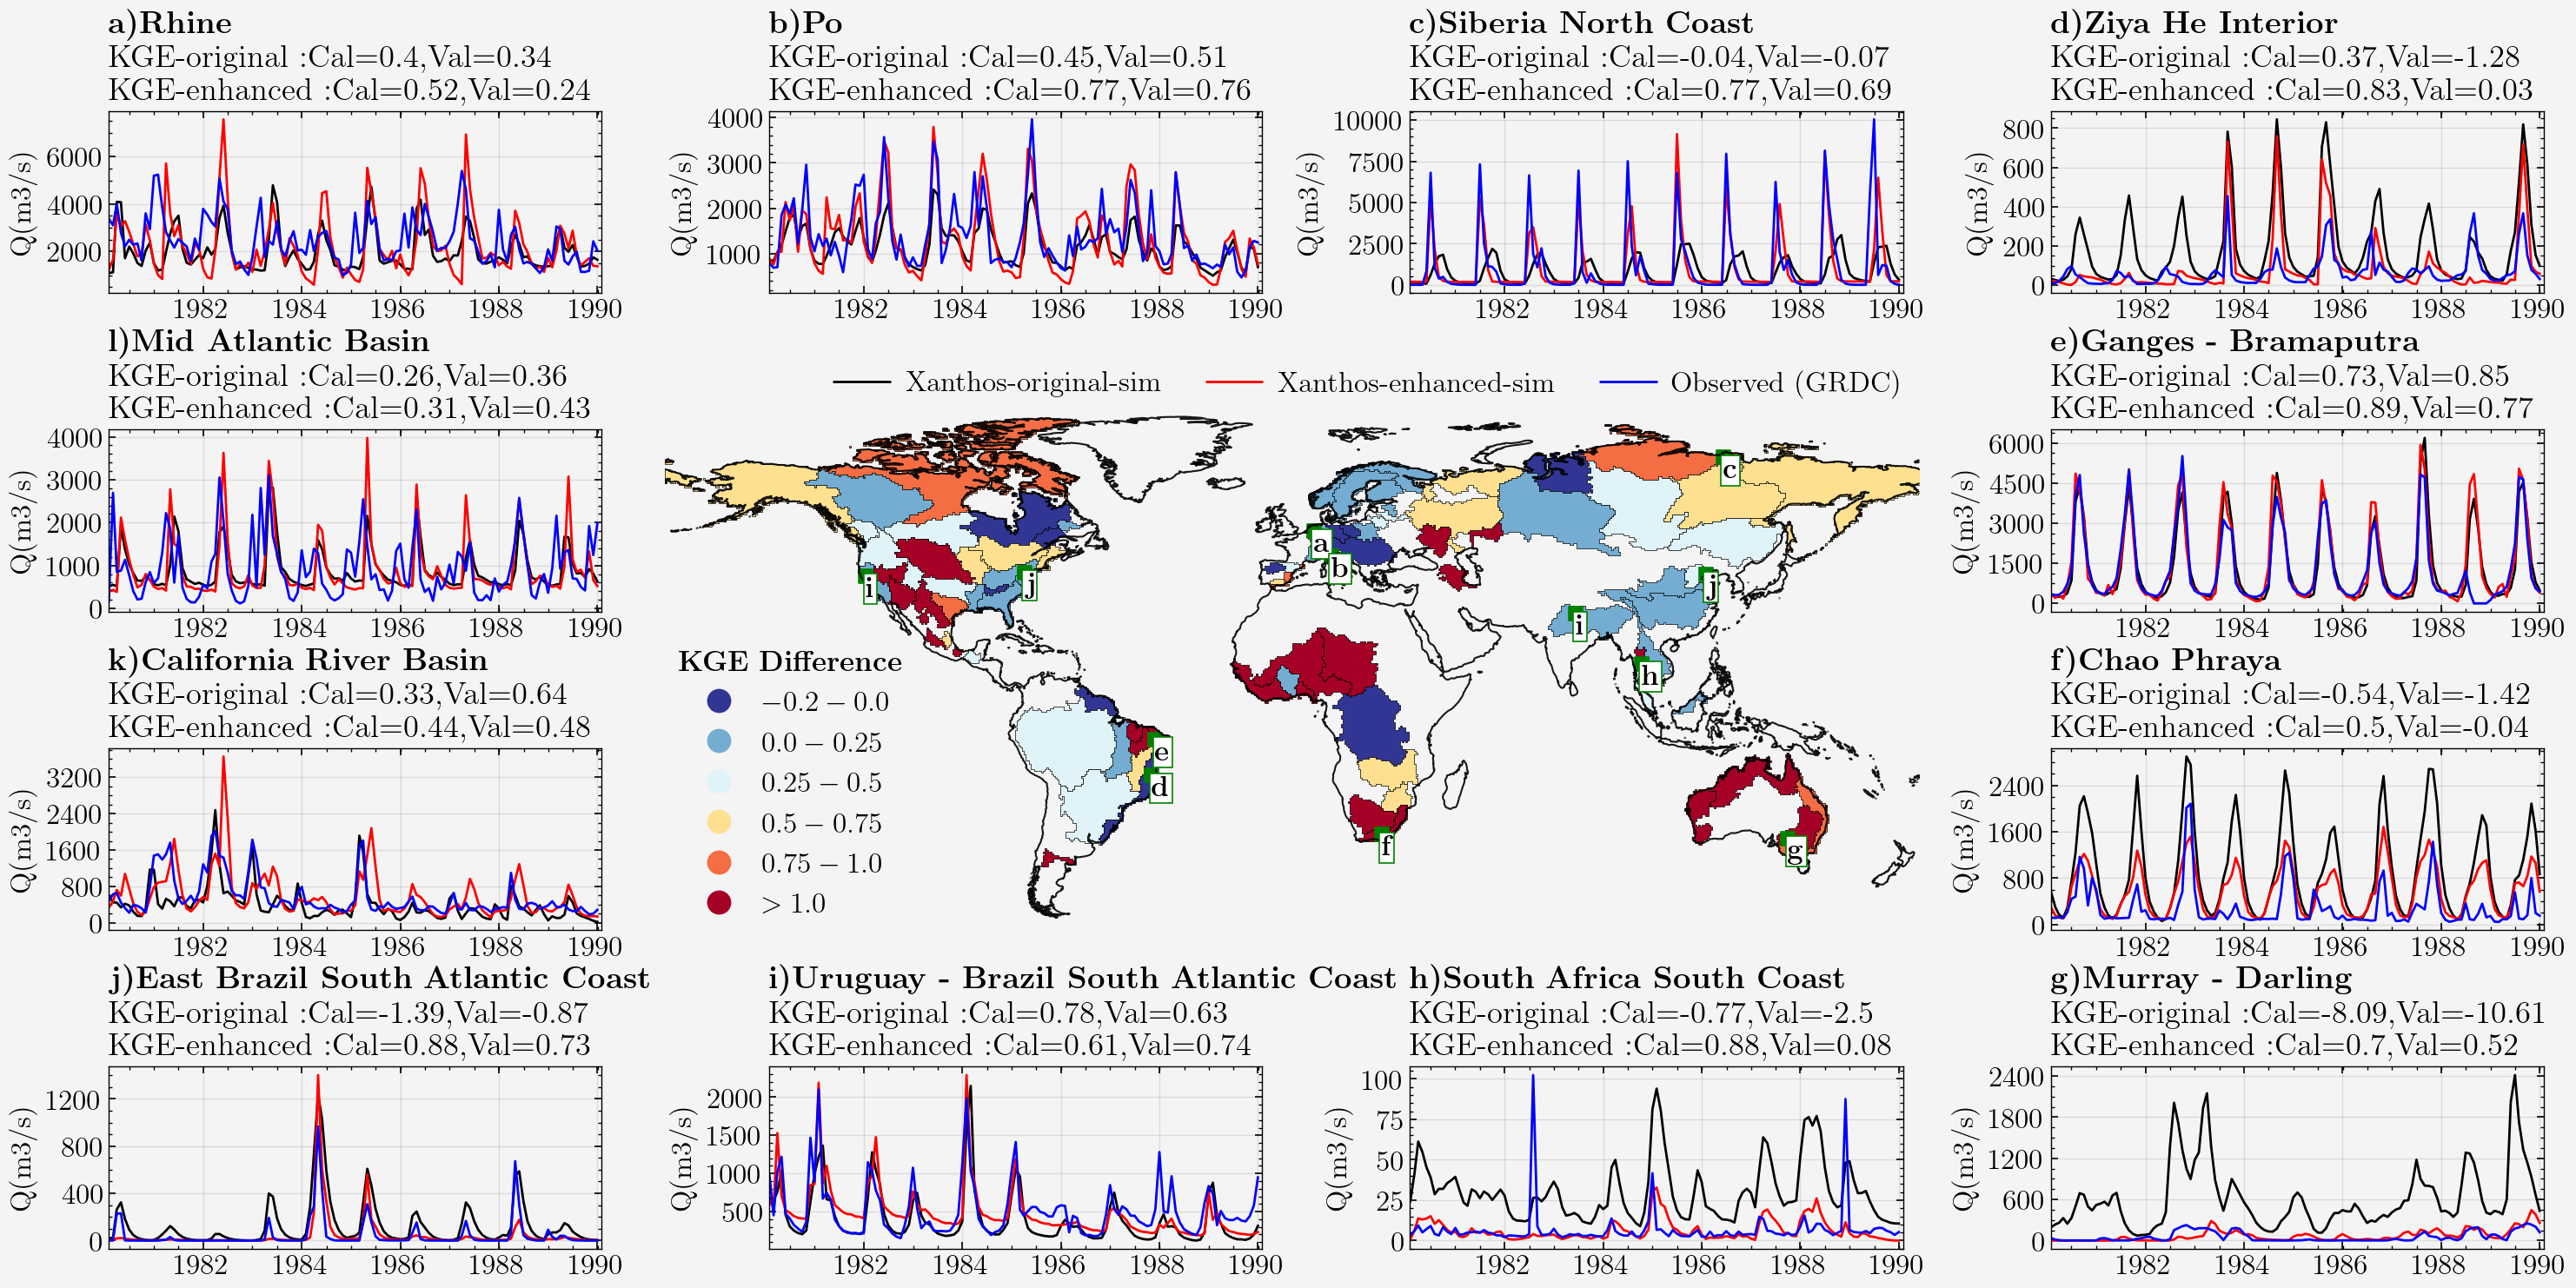

In [20]:
import xarray 
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import proplot as pplt

mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
plt.rcParams['figure.autolayout'] = True 
plt.rcParams.update({'font.size': 12, 'font.weight':'bold'}) 



plt.rcParams["axes.labelweight"] = 'bold'
plt.rcParams["axes.titleweight"] = 'bold'

CRS = "EPSG:4326"
## Ploting
SAVE_KWDS = {"bbox_inches": "tight", "dpi": 450, "facecolor": "w"}
BASE_PLOT = {"facecolor": 'none', "edgecolor": 'k', "alpha": 0.9,"linewidth":0.75}

world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
global_shape = gpd.GeoDataFrame(geometry=world.geometry, crs=world.crs)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
basins_selected_all = [32, 57, 3, 77, 110, 146, 208, 198, 195, 186, 217, 233]
grdc = pd.read_csv('D:\Xanthos GranD and GRDC Data\Demand_for_selected_GRDC_stations_Basins_2.0.csv')
xy, x_ind, y_ind = np.intersect1d(basins_selected_all, grdc.basins.values, return_indices=True)
grdc_selected = grdc.loc[y_ind]

#coastlines
#coastlines
coastlines_path = 'D:\\Xanthos-Repo\\ne_50m_coastline\\ne_50m_coastline.shp'
coastlines = gpd.read_file(coastlines_path)
# rivers
rivers = gpd.read_file('D:\\Xanthos-Repo\\Xanthos-Manuscript\\figures\\codes\\Figure-3\\world_rivers_dSe\\world_rivers_dSe.shp')

N=10
c = np.linspace(-N / 2, N / 2, N + 1)
fig, axes = pplt.subplots(nrows=1, ncols=1, share=0, space = 2, refheight='3.10')
plt.style.use('science')
with plt.style.context(['science', 'high-contrast']):
        # GranD
        ax = axes
        coastlines.to_crs(CRS).plot(ax=ax,**BASE_PLOT)  
        basin_235_xanthos_KGEDiff.to_crs(CRS).plot(ax=ax, column='KGEDiffGroup', cmap='RdYlBu_r', 
                                         categorical=True,  edgecolor='k',linewidth=0.25,
                                         legend=True,
                                         legend_kwds={'loc': 'lower left',
                                                       'ncols':1,
                                                       'label' : r'$\bf{{{\ \ \ KGE\ Difference}}}$',
                                                       'edgecolor':'black',
                                                       'facecolor':'white'
                                                       }
                                                       )                                                                                  
        ax.axis(False)
        ax.xaxis.label.set_visible(False)
        ax.yaxis.label.set_visible(False)
        ax.autoscale(tight=True)  
        ax.set_ylim([-60,90])   
        ax.format(abc=False)
        title_abcx = ['a','b','c','j','i','h','g','f','d','e', 'i', 'j', 'k', 'l']
        for ii in range(len(basins_selected_all)):
                jj = np.where(grdc_selected.basins.values == basins_selected_all[ii])[0]
                ax.scatter(grdc_selected.lon_adj.values[jj], grdc_selected.lat_adj.values[jj], marker ='s', color='g')
                ax.text(grdc_selected.lon_adj.values[jj], grdc_selected.lat_adj.values[jj], r'$\bf{{{' + title_abcx[ii] + '}}}$', 
                        bbox=dict(facecolor='white', edgecolor='green', pad=1.0),
                        color = 'k', verticalalignment="top", fontsize=12 , zorder=2)
 
#         #ax.format(abc=False,  titleweight = 'bold', titleloc='l',abcstyle=False, fontsize=12)
#         #ax.legend(bbox_to_anchor=(1.0, .5), prop={'size': 12})
        
        plot_basin_data(basins_selected_all)



dir_out = 'C:\\Users\\gwabeshu.COUGARNET\\OneDrive - University Of Houston\\Desktop\Xanthos-Manuscript\\Manuscript-09072022\\revised-11-01-2022\\figures\\'
#plt.savefig(dir_out  + "Figure-5-KGE+Time-Series-HPFC.png", **SAVE_KWDS)  